# The best neighbourhoods in Toronto for a middle class family with underage children.

Andrés C. Sarmiento G. 
Feb/04/2020

In [1]:
! conda install -c conda-forge geopy --yes
! conda install -c conda-forge folium --yes
! conda install -c conda-forge xlrd --yes
! conda install -c conda-forge lxml --yes
%matplotlib inline
import folium
from folium import plugins
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import geopy
from sklearn import linear_model
from geopy.geocoders import Nominatim
from geopy.distance import geodesic 
from geopy.extra.rate_limiter import RateLimiter
import requests 
from IPython.display import Image 
from IPython.core.display import HTML 
from pandas.io.json import json_normalize

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.5.11
  latest version: 4.8.2

Please update conda by running

    $ conda update -n base -c defaults conda



## Package Plan ##

  environment location: /home/jupyterlab/conda/envs/python

  added / updated specs: 
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    certifi-2019.11.28         |           py36_0         149 KB  conda-forge
    scikit-learn-0.20.1        |   py36h22eb022_0         5.7 MB
    liblapack-3.8.0            |      11_openblas          10 KB  conda-forge
    numpy-1.18.1               |   py36h95a1406_0         5.2 MB  conda-forge
    liblapacke-3.8.0           |      11_openblas          10 KB  conda-forge
    geographiclib-1.50         |             py_0          34 KB  conda-forge
    libopenblas-0.3.6          |       h5a2b251_2         7.7 MB
    sci

# 1. Introduction
Toronto, a city in southeast Canada, capital of the province of Ontario, located in the southern part of the province, on the shores of Lake Ontario and at the mouth of the Humber and Don rivers. 
The city is the economic, commercial, industrial and cultural centre of the country and the largest metropolitan area in Canada.  Toronto is the largest city in Ontario and the second most populous in Canada. Today, it is a cosmopolitan city that is home to many different cultures and ethnicities.

According to immigration data in Canada, for 2010, Ontario received 41% of all immigrants to that country from countries such as the Philippines, India, China, United Kingdom, among others, being this the province with the largest number of immigrants in the country. 

The causes of migration can be various: the search for a better quality of life and work opportunities, or simply a labour obligation.

Given the high level of immigration, this research aims to help families with children who arrive in Toronto to be able to locate themselves permanently with ease in the neighbourhoods that best suit their needs and where the price of the houses is acceptable to their socio-economic status.

## 2. Data
In order to solve the problem posed, the following data will be taken into account in the investigation:
### Open data:
* We will extract the neighborhoods in Toronto from the Wikipedia table provided in the article: https://en.wikipedia.org/wiki/List_of_city-designated_neighbourhoods_in_Toronto
* We will examine crime in Toronto in the period 2014-2019 based on official reports from the city police in order to place the family in a safe and healthy environment: http://data.torontopolice.on.ca/datasets/mci-2014-to-2019
* We will look at the average value of absorbed and unabsorbed housing in each neighbourhood in Toronto so that families can more easily find housing according to their socio-economic status, thanks to the data provided by CMHC: https://www03.cmhc-schl.gc.ca/hmip-pimh/en/TableMapChart#TableMapChart/2270/3/Toronto
* We will review the number of schools near each neighbourhood using data provided by the City of Toronto to ensure that children have access to different educational opportunities: https://open.toronto.ca/dataset/school-locations-all-types/

### Foursquare:
We will examine if the necessary services exist for each neighborhood for the family as:
* Health: 
   * Hospitals.
   * Doctor's offices.
* Transportation:
    * Metro stations.
    * Streetcar stations.
* Food and shopping:
    * Shopping centres
* Recreation and sport:
    * Parks.
    * Children's parks.

## 3. Methodology

### 1. Selection and data collection

1. We will extract the list of neighborhoods from the Wikipedia article mentioned in the "Data" section and only keep the "ID", "Neighborhoods" and "Municipality" columns. This will be our basis for building the main table.

In [2]:
df = pd.read_html("https://en.wikipedia.org/wiki/List_of_city-designated_neighbourhoods_in_Toronto")[0]

In [3]:
df.rename(columns={'City-designated neighbourhood': 'Neighbourhood'}, inplace=True)
df.drop(df.columns.difference(['CDN number','Neighbourhood','Former city/borough']),1, inplace=True)

In [4]:
df.sort_values(by=["CDN number"], inplace=True)
df.rename(columns={'CDN number': 'ID','Former city/borough': 'Municipality'}, inplace=True)
df.rename(columns={}, inplace=True)
df.reset_index(drop = True, inplace = True)

2. For crime data, since each row means a crime report, we will count how many times the names of the neighborhoods are repeated and sort that list by the neighborhood ID.

In [5]:
crimeData = pd.read_csv("https://opendata.arcgis.com/datasets/f4c2e5de021f4836a3caf77f8421f487_0.csv?outSR=%7B%22latestWkid%22%3A3857%2C%22wkid%22%3A102100%7D")

In [6]:
crimeData['Total major crimes'] = crimeData.groupby('Neighbourhood')['Neighbourhood'].transform('count')

3. Although the CMHC site presents the average value of homes per neighborhood annually, they are not always able to collect information from all neighborhoods. Therefore, we will combine the data presented in the period 2014-2019 and save that information in a CSV document in the cloud.

In [7]:
homePrices = pd.read_csv("https://docs.google.com/spreadsheets/d/1c5tjk4QYdd_wmN0BkK1-UfzXctR5wtYWbU8ysVb58Jg/export?format=csv&id=1c5tjk4QYdd_wmN0BkK1-UfzXctR5wtYWbU8ysVb58Jg&gid=2130659245")

4. We will find out the geographic location of each neighborhood as follows:
    * We'll use the GeoPy library to find the geographic location of each neighborhood and store those values in the "Latitude" and "Longitude" columns.    

In [8]:
geolocator = Nominatim(user_agent = "Frituras")
geocode = RateLimiter(geolocator.geocode, min_delay_seconds=0.5)
df["Coordinates"] = (df["Neighbourhood"] + ", ONTARIO").apply(geolocator.geocode)

In [9]:
df["Latitude"] = df["Coordinates"].apply(lambda x: x.latitude if x !=None else None)
df["Longitude"] = df["Coordinates"].apply(lambda x: x.longitude if x !=None else None)

4. ...
    * Since the GeoPy service has not found the geographic location of a few neighborhoods, we will use the geographic information provided by the crime data table, since we have a record of the location of each crime by neighborhood. To improve geographic accuracy, we will find the average between the coordinates for each neighborhood and add that information to the remaining spaces in the main table.

In [10]:
crimeData['Lat'] = crimeData.groupby('Neighbourhood')['Lat'].transform('mean')
crimeData['Long'] = crimeData.groupby('Neighbourhood')['Long'].transform('mean')
crimeData.drop_duplicates("Neighbourhood", inplace=True)
crimeData.drop(crimeData.columns.difference(['Hood_ID', 'Neighbourhood', 'Lat', 'Long', 'Total major crimes']),1, inplace=True)
crimeData.sort_values(by=["Hood_ID"], inplace=True)
crimeData.drop_duplicates("Hood_ID", inplace=True)
crimeData.reset_index(drop = True, inplace = True)

In [11]:
df["Latitude"].fillna(crimeData["Lat"],inplace=True)
df["Longitude"].fillna(crimeData["Long"],inplace=True)

5. We will now locate the sites that provide the services of interest mentioned in the "Data" section:
    * Using the Geodesic function of GeoPy we will find out how many schools there are per neighbourhood within a radius of 1200m by comparing the geographical coordinates of the neighbourhoods and the schools which are registered in their respective table. The information obtained will be stored in a CSV file in the cloud.    

In [12]:
schoolData = pd.read_csv("https://ckan0.cf.opendata.inter.prod-toronto.ca/download_resource/02ef7447-54d9-4aa7-b76d-8ef8138ac546?format=csv&projection=4326")
schoolData.drop(schoolData.columns.difference(['NAME','SCHOOL_TYPE_DESC','MUNICIPALITY','LATITUDE','LONGITUDE']),1, inplace=True)
schoolData['MUNICIPALITY'][schoolData.MUNICIPALITY.str.contains('former Toronto')] = "Old City of Toronto"

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [13]:
schoolDistance = pd.read_csv("https://docs.google.com/spreadsheets/d/15s3AKzoje9rIow8UEgCbSEPihNc8Mm7I3r0mtPt--Zs/export?format=csv&id=15s3AKzoje9rIow8UEgCbSEPihNc8Mm7I3r0mtPt--Zs&gid=729909667")
schoolDistanceCount = schoolDistance.groupby(["Neighbourhood SCH"]).size().reset_index(name='Schools') 
schoolDistanceCount.drop(schoolDistanceCount.columns.difference(['Neighbourhood SCH',"Schools"]),1, inplace=True)

5. ...
  * Using the FourSquare API we will perform the following searches and save the results in an Excel book in the cloud:
        * The existence of a hospital within a radius of 2500m
        * The existence of medical offices within a radius of 700m (3 is a very acceptable number)
        * The existence of metro and tram stations within a radius of 600m (5 is a very acceptable number)
        * The existence of a shopping centre within a radius of 1000m
        * The existence of parks and playgrounds within a radius of 400m (2 is a very acceptable number)

In [14]:
malls = pd.read_excel("https://docs.google.com/spreadsheets/d/1bbJhabjyjRykhxYEY591rycXiVIlF1x_BFGUv5OB3eg/export?format=xlsx&id=1bbJhabjyjRykhxYEY591rycXiVIlF1x_BFGUv5OB3eg", sheet_name=4)
mallsCount = malls.groupby(["Neighbourhood M"]).size().reset_index(name='Malls') 
mallsCount.drop(mallsCount.columns.difference(['Neighbourhood M','Malls']),1, inplace=True)

In [15]:
hospitals = pd.read_excel("https://docs.google.com/spreadsheets/d/1bbJhabjyjRykhxYEY591rycXiVIlF1x_BFGUv5OB3eg/export?format=xlsx&id=1bbJhabjyjRykhxYEY591rycXiVIlF1x_BFGUv5OB3eg", sheet_name=1)
hospitalsCount = hospitals.groupby(["Neighbourhood H"]).size().reset_index(name='Hospitals') 
hospitalsCount.drop(hospitalsCount.columns.difference(['Neighbourhood H','Hospitals']),1, inplace=True)

In [16]:
metroStations = pd.read_excel("https://docs.google.com/spreadsheets/d/1bbJhabjyjRykhxYEY591rycXiVIlF1x_BFGUv5OB3eg/export?format=xlsx&id=1bbJhabjyjRykhxYEY591rycXiVIlF1x_BFGUv5OB3eg", sheet_name=3)
metroStationsCount = metroStations.groupby(["Neighbourhood MS"]).size().reset_index(name='Metro stations') 
metroStationsCount.drop(metroStationsCount.columns.difference(['Neighbourhood MS','Metro stations']),1, inplace=True)

In [17]:
playground = pd.read_excel("https://docs.google.com/spreadsheets/d/1bbJhabjyjRykhxYEY591rycXiVIlF1x_BFGUv5OB3eg/export?format=xlsx&id=1bbJhabjyjRykhxYEY591rycXiVIlF1x_BFGUv5OB3eg", sheet_name=2)
playgroundCount = playground.groupby(["Neighbourhood PG"]).size().reset_index(name='Playground') 
playgroundCount.drop(playgroundCount.columns.difference(['Neighbourhood PG','Playground']),1, inplace=True)

In [18]:
doctorOffices = pd.read_excel("https://docs.google.com/spreadsheets/d/1bbJhabjyjRykhxYEY591rycXiVIlF1x_BFGUv5OB3eg/export?format=xlsx&id=1bbJhabjyjRykhxYEY591rycXiVIlF1x_BFGUv5OB3eg", sheet_name=0)
doctorOfficesCount = doctorOffices.groupby(["Neighbourhood DO"]).size().reset_index(name="Doctor's office") 
doctorOfficesCount.drop(doctorOfficesCount.columns.difference(['Neighbourhood DO',"Doctor's office"]),1, inplace=True)

In [19]:
parks = pd.read_excel("https://docs.google.com/spreadsheets/d/1bbJhabjyjRykhxYEY591rycXiVIlF1x_BFGUv5OB3eg/export?format=xlsx&id=1bbJhabjyjRykhxYEY591rycXiVIlF1x_BFGUv5OB3eg", sheet_name=5)
parksCount = parks.groupby(["Neighbourhood P"]).size().reset_index(name='Parks') 
parksCount.drop(parksCount.columns.difference(['Neighbourhood P','Parks']),1, inplace=True)

In [20]:
streetcar = pd.read_excel("https://docs.google.com/spreadsheets/d/1bbJhabjyjRykhxYEY591rycXiVIlF1x_BFGUv5OB3eg/export?format=xlsx&id=1bbJhabjyjRykhxYEY591rycXiVIlF1x_BFGUv5OB3eg", sheet_name=6)
streetcarCount = streetcar.groupby(["Neighbourhood S"]).size().reset_index(name='Streetcar') 
streetcarCount.drop(streetcarCount.columns.difference(['Neighbourhood S','Streetcar']),1, inplace=True)

### 2. Data processing and transformation
Once we have obtained the necessary information, we must put together the data collected in a single table to facilitate our work.

##### 2.1 Formatting the data
The presentation of the table of household prices is not in the same format as the rest of the information, since in the column containing the names of the neighbourhoods, some cells group together more than one name. To correct this, the grouped neighbourhoods were separated into separate cells.

Reviewing the table that provides information about the schools in Toronto, some elements of the "Municipality" column referred to the municipality of "Old city of Toronto" with the text "former of Toronto", so that text string was replaced with the actual name of the mentioned municipality.

Now that all the tables share a similar format in the column of the districts, an OUTER JOIN operation is performed, that is, we insert the values of the districts that share the tables with the main table. 

In [21]:
df["Total major crimes"] = crimeData["Total major crimes"]

In [22]:
df = df.merge(schoolDistanceCount, left_on='Neighbourhood', right_on='Neighbourhood SCH', how='left').fillna(0)

In [23]:
df = df.merge(homePrices, left_on='Neighbourhood', right_on='Neighbourhoods', how='left')

In [24]:
df = df.merge(mallsCount, left_on='Neighbourhood', right_on='Neighbourhood M', how='left').fillna(0)
df = df.merge(hospitalsCount, left_on='Neighbourhood', right_on='Neighbourhood H', how='left').fillna(0)
df = df.merge(metroStationsCount, left_on='Neighbourhood', right_on='Neighbourhood MS', how='left').fillna(0)
df = df.merge(playgroundCount, left_on='Neighbourhood', right_on='Neighbourhood PG', how='left').fillna(0)
df = df.merge(doctorOfficesCount, left_on='Neighbourhood', right_on='Neighbourhood DO', how='left').fillna(0)
df = df.merge(streetcarCount, left_on='Neighbourhood', right_on='Neighbourhood S', how='left').fillna(0)
df = df.merge(parksCount, left_on='Neighbourhood', right_on='Neighbourhood P', how='left').fillna(0)

Then we combine the columns for metro and tram stations, as well as parks and playgrounds. 

In [25]:
df["Metro/Streetcar stations"] = df["Metro stations"] + df["Streetcar"]
df["Parks"] = df["Playground"] + df["Parks"]

Finally, we eliminated the remaining columns, reorganized the table and changed the values from type "float" to type "int".

In [26]:
df.drop(["Neighbourhoods", "Coordinates", "Neighbourhood SCH", "Neighbourhood DO", "Neighbourhood P", "Neighbourhood H", "Neighbourhood MS", "Neighbourhood M", "Neighbourhood PG", "Neighbourhood S", "Playground", "Streetcar", "Metro stations"],axis=1,inplace=True)

In [27]:
df = df[['ID','Neighbourhood','House prices','Total major crimes','Latitude','Longitude','Municipality','Schools','Hospitals',"Doctor's office",'Metro/Streetcar stations','Malls','Parks']]

In [28]:
cols = ['ID','House prices','Total major crimes','Schools','Hospitals',"Doctor's office",'Metro/Streetcar stations','Malls','Parks']
df[cols] = df[cols].astype('int')

##### 2.2 Dealing with missing data.
After the previous operation, we realize that we have missing data spaces for the column of house prices. Since that data is very important information within our investigation, we cannot afford to simply ignore those rows, so we completed those fields by predicting through a simple linear regression, the possible price of the houses based on a variable that has a potential correlation, and in this case, the independent variable chosen was the number of crimes per neighborhood.

In [29]:
df['House prices'].replace(0.0, np.NaN, inplace =True)

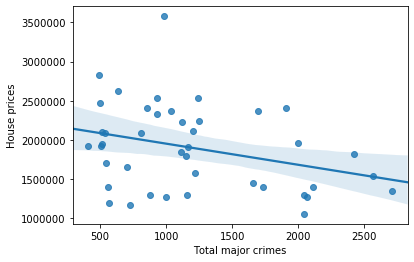

In [30]:
sns.regplot(x="Total major crimes", y="House prices", data=df)

In [31]:
df_select = df[['House prices', 'Total major crimes', 'Schools']].dropna().reset_index(drop=True)

In [32]:
regr = linear_model.LinearRegression()
train_x = np.asanyarray(df_select[['Total major crimes']])
train_y = np.asanyarray(df_select[['House prices']])
regr.fit (train_x, train_y)
# The coefficients
print ('Coefficients: ', regr.coef_)
print ('Intercept: ',regr.intercept_)

Coefficients:  [[-269.51880273]]
Intercept:  [2222161.52564824]


In [33]:
df["House prices"].fillna((round(2222161.52564824 +(-269.51880273 *df["Total major crimes"]), 0)), inplace=True)

##### 2.3 Data storage and mining.
_It is pertinent to remember that the data obtained from FourSquare was stored in an Excel book in the cloud so as not to depend on the maximum number of queries that can be made daily._

_Similarly, the data obtained from the distance between the neighbourhood and the schools was stored in a CSV file in the cloud._

Once the previous steps have been completed, we now have an organized, descriptive and readable table.

In [34]:
pd.set_option('display.max_rows', None)
df

,ID,Neighbourhood,House prices,Total major crimes,Latitude,Longitude,Municipality,Schools,Hospitals,Doctor's office,Metro/Streetcar stations,Malls,Parks
0,1,West Humber-Clairville,685365.0,5702,43.721487,-79.597169,Etobicoke,2,1,3,0,1,0
1,2,Mount Olive-Silverstone-Jamestown,1523838.0,2591,43.745418,-79.587672,Etobicoke,13,1,1,0,1,1
2,3,Thistletown-Beaumond Heights,2035655.0,692,43.738422,-79.566848,Etobicoke,5,1,1,0,1,0
3,4,Rexdale-Kipling,2003851.0,810,43.722114,-79.572292,Etobicoke,7,1,1,0,1,0
4,5,Elms-Old Rexdale,2062337.0,593,43.720345,-79.557102,Etobicoke,13,0,0,0,1,0
5,6,Kingsview Village-The Westway,1883915.0,1255,43.696826,-79.551188,Etobicoke,10,0,3,0,1,0
6,7,Willowridge-Martingrove-Richview,1884724.0,1252,43.682717,-79.556812,Etobicoke,11,0,3,0,1,0
7,8,Humber Heights-Westmount,2084976.0,509,43.688470,-79.506390,Etobicoke,2,1,0,0,0,1
8,9,Edenbridge-Humber Valley,2622444.0,634,43.672223,-79.514685,Etobicoke,2,1,0,0,1,3
9,10,Princess-Rosethorn,1395455.0,563,43.668996,-79.546663,Etobicoke,5,1,0,0,0,0


Now is the time to look for the best neighborhoods for the family based on their needs and their socioeconomic status. Our priority factors are the search for a neighborhood with a healthy environment, with below-average crime and housing prices that are equal to or lower than the city average.

## 4. Results
Taking into account that the potential neighborhoods to be suggested must have a crime rate below the average and the value of the houses must be equal or lower than the average in order to be affordable according to the family's socioeconomic status, we obtained the following list of the 10 neighborhoods that meet these requirements.

In [35]:
df_results = df[(df['House prices'] <= df["House prices"].mean()) & (df['Total major crimes'] <= df["Total major crimes"].mean())].reset_index(drop=True)
df_results

,ID,Neighbourhood,House prices,Total major crimes,Latitude,Longitude,Municipality,Schools,Hospitals,Doctor's office,Metro/Streetcar stations,Malls,Parks
0,10,Princess-Rosethorn,1395455.0,563,43.668996,-79.546663,Etobicoke,5,1,0,0,0,0
1,16,Stonegate-Queensway,1795000.0,1148,43.621950,-79.523499,Etobicoke,1,1,1,0,1,2
2,18,New Toronto,1278000.0,996,43.600763,-79.505264,Etobicoke,6,1,1,0,0,4
3,19,Long Branch,1173000.0,725,43.592005,-79.545365,Etobicoke,2,1,1,0,1,4
4,20,Alderwood,1706333.0,545,43.601717,-79.545232,Etobicoke,3,1,2,0,1,4
5,64,Woodbine Corridor,1295000.0,877,43.677091,-79.315792,Old City of Toronto,13,1,2,1,0,3
6,65,Greenwood-Coxwell,1295000.0,1155,43.672558,-79.324289,Old City of Toronto,17,1,2,1,0,2
7,67,Playter Estates-Danforth,1649500.0,707,43.678728,-79.353711,Old City of Toronto,13,1,3,2,1,3
8,102,Forest Hill North,1199000.0,565,43.693559,-79.413902,Old City of Toronto,7,1,0,0,1,2
9,123,Cliffcrest,1582308.0,1217,43.721939,-79.236232,Scarborough,7,1,1,0,0,0


From these data, we can infer that the municipalities of "Old City of Toronto" and "Etobicoke" are good places to live because they have safe neighbourhoods and affordable housing.
Let's explore the neighbourhoods and the distribution of the services that each one offers.

In [36]:
toronto_map = folium.Map(location=[43.7250, -79.4257], control_scale=True, zoom_start=11)

neighborhood_1 = folium.FeatureGroup(name="Princess-Rosethorn").add_to(toronto_map)
neighborhood_2 = folium.FeatureGroup(name="Stonegate-Queensway").add_to(toronto_map)
neighborhood_3 = folium.FeatureGroup(name="New Toronto").add_to(toronto_map)
neighborhood_4 = folium.FeatureGroup(name="Long Branch").add_to(toronto_map)
neighborhood_5 = folium.FeatureGroup(name="Alderwood").add_to(toronto_map)
neighborhood_6 = folium.FeatureGroup(name="Woodbine Corridor").add_to(toronto_map)
neighborhood_7 = folium.FeatureGroup(name="Greenwood-Coxwell").add_to(toronto_map)
neighborhood_8 = folium.FeatureGroup(name="Playter Estates-Danforth").add_to(toronto_map)
neighborhood_9 = folium.FeatureGroup(name="Forest Hill North").add_to(toronto_map)
neighborhood_10 = folium.FeatureGroup(name="Cliffcrest").add_to(toronto_map)

neighborhoods = [neighborhood_1,neighborhood_2,neighborhood_3,neighborhood_4,neighborhood_5,neighborhood_6,neighborhood_7,neighborhood_8,neighborhood_9,neighborhood_10]

i = 0

for neighborhood, in zip(df_results.Neighbourhood):
    schools_select = schoolDistance[(schoolDistance['Neighbourhood SCH'] == neighborhood)]
    hospitals_select = hospitals[(hospitals['Neighbourhood H'] == neighborhood)]
    doctorOffice_select = doctorOffices[(doctorOffices['Neighbourhood DO'] == neighborhood)]
    metroStations_select = metroStations[(metroStations['Neighbourhood MS'] == neighborhood)]
    streetcarStations_select = streetcar[(streetcar['Neighbourhood S'] == neighborhood)]  
    malls_select = malls[(malls['Neighbourhood M'] == neighborhood)] 
    parks_select = parks[(parks['Neighbourhood P'] == neighborhood)]
    playground_select = playground[(playground['Neighbourhood PG'] == neighborhood)]
    
    for lat, lng, in zip(schools_select.SCH_Latitude, schools_select.SCH_Longitude):
        neighborhoods[i].add_child(folium.Marker([lat, lng], icon=folium.Icon(color='beige', icon='fa-graduation-cap', prefix='fa')))
    
    for lat, lng, in zip(hospitals_select.location_lat, hospitals_select.location_lng):
        neighborhoods[i].add_child(folium.Marker([lat, lng], icon=folium.Icon(color='red', icon='fa-h-square', prefix='fa')))   
    
    for lat, lng, in zip(doctorOffice_select.location_lat, doctorOffice_select.location_lng):
        neighborhoods[i].add_child(folium.Marker([lat, lng], icon=folium.Icon(color='lightred', icon='fa-stethoscope', prefix='fa')))     
    
    for lat, lng, in zip(metroStations_select.location_lat, metroStations_select.location_lng):
        neighborhoods[i].add_child(folium.Marker([lat, lng], icon=folium.Icon(color='lightblue', icon='fa-bus', prefix='fa')))     
    
    for lat, lng, in zip(streetcarStations_select.location_lat, streetcarStations_select.location_lng):
        neighborhoods[i].add_child(folium.Marker([lat, lng], icon=folium.Icon(color='lightblue', icon='fa-bus', prefix='fa')))     
    
    for lat, lng, in zip(malls_select.location_lat, malls_select.location_lng):
        neighborhoods[i].add_child(folium.Marker([lat, lng], icon=folium.Icon(color='orange', icon='fa-shopping-bag', prefix='fa')))     
    
    for lat, lng, in zip(parks_select.location_lat, parks_select.location_lng):
        neighborhoods[i].add_child(folium.Marker([lat, lng], icon=folium.Icon(color='green', icon='fa-tree', prefix='fa')))     
    
    for lat, lng, in zip(playground_select.location_lat, playground_select.location_lng):
        neighborhoods[i].add_child(folium.Marker([lat, lng], icon=folium.Icon(color='green', icon='fa-tree', prefix='fa')))  
    
    i=i+1    
    
folium.LayerControl().add_to(toronto_map)

In [37]:
toronto_map

## 5. Discussion
Analyzing the data obtained, we observe that in all the neighborhoods we have hospital service, supplying an important need for the family.
However, we can identify a neighborhood that has all the services that may be of interest to the family to supply their primary and secondary needs: **Playter Estates-Danforth**, since it has a wide range of academic institutions (11), it has a shopping center, of the ten neighborhoods it is the one with the most doctors' offices (3), it has a good number of parks (3) and it is close to two mass transport stations (tram/metro) so the distance from home to the workplace will not be a problem in most cases.
![Playter Estates-Danforth](https://www.torontoneighbourhoods.net/content/963/P1010216(1)_560x350.gif)

Of course, the other options are up to each family interested in moving to Toronto, as each may prioritize services differently according to their convenience.

## 6. Conclussion
Throughout this research, we have travelled around the city of Toronto in order to generate suggestions for the middle-class immigrant families with children that the city receives every day. Through the study and management of multiple data sources, we generated a list of recommendations that are in line with the family's socio-economic situation and the services that can improve their quality of life. 

I sincerely hope that this information has been useful to you and that it has served as a guide for you to be able to move and establish yourself permanently in the city of Toronto.

## 7. Acknowledgements
A warm thank you to the engineers, professors and scientists at IBM who provided me with the invaluable knowledge to develop this project.

A huge thank you to the community of students who were always willing to solve my doubts and to qualify my work in a constructive way.

I also thank the entire Foursquare community and its engineers and the Toronto public officials who created and released these valuable knowledge bases to the public.

To all, thank you very much for your invaluable collaboration.